$\Large{\text{Ensemble methods - Part 2}}$ 

$\large{\text{Bagging}}$ 



Let us first generate a synthetic data set.

We shall generate $n$ ($n$ being even) samples where the feature vector of each sample is 2-dimensional of the form $x^i = (x^i_1,x^i_2), i \in \{1,2,\ldots,n\}$. We assume that $\frac{n}{2}$ samples are from a spiral shaped data set called $S_1$ and other $\frac{n}{2}$ samples are from a different spiral called $S_2$. For each sample $x^i$ we have the following labeling scheme:

$
\begin{align}
y^i = \begin{cases}
        +1 \text{ if } x^i \in S_1 \\ 
        -1 \text{ if }  x^i \in S_2.
      \end{cases}
\end{align}
$

Here the spirals $S_1$ and $S_2$ are associated with the parametric forms: 
$x_1 = r_1(\varphi) \cos \varphi$ and $x_2 = r_2(\varphi) \sin \varphi$ where$\varphi$ the angle and $r(\varphi)$ is a (monotonically increasing or decreasing) radius function depending on the angle $\varphi$. The coordinates are $x_1$ and $x_2$.  



(100, 2)
(100,)


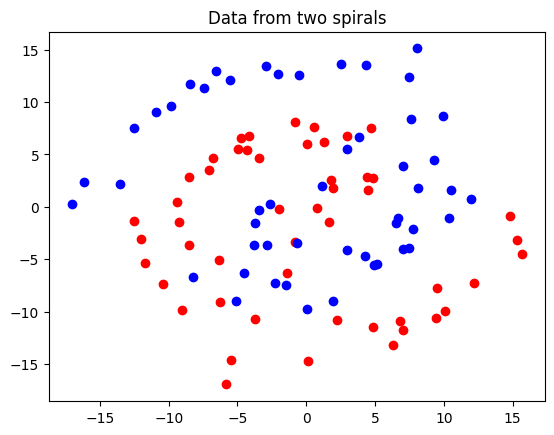

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

num_samples = 100
angle = np.linspace(0,2*pi,int(num_samples/2))
mean = [0.0, 0.0]
cov = [ [6.0, 6.0], [6.0, 6.0] ] 

X = np.zeros( (num_samples, 2) ) 

r_1 = 2*angle + pi
data_1 = np.array([np.cos(angle)*r_1, np.sin(angle)*r_1]).T
#print(data_1.shape)
X_1 = data_1 + np.random.multivariate_normal(mean, cov, int(num_samples/2)) #np.random.randn(int(num_samples/2),2)
X[:int(num_samples/2),:] = X_1

r_2 = -2*angle - pi
data_2 = np.array([np.cos(angle)*r_2, np.sin(angle)*r_2]).T
X_2 = data_2 + np.random.multivariate_normal(mean, cov, int(num_samples/2)) #np.random.randn(int(num_samples/2),2)
X[int(num_samples/2):,:] = X_2

y = np.ones(num_samples)
y[int(num_samples/2):] = -1*y[int(num_samples/2)]
#print(y)


print(X.shape)
print(y.shape)

figure, axes = plt.subplots(1) 
 

plt.scatter(X[:int(num_samples/2),0],X[:int(num_samples/2),1], marker='o', color='red')
plt.scatter(X[int(num_samples/2):,0],X[int(num_samples/2):,1], marker='o', color='blue')


plt.title( 'Data from two spirals' ) 
plt.show() 


Consider an input space $\mathcal{X} \subseteq {\mathbb{R}}^d$ and the output space $\mathcal{Y} = \{+1,-1\}$. Assume a fixed (but unknown) distribution $P(X,Y)$ over $\mathcal{X} \times \mathcal{Y}$. 

Recall that we are given a training set $D=\{(x^i,y^i)\}_{i=1}^{N}$. 

We shall now discuss an iterative procedure called $\large{\text{Bagging}}$.

1. We start with $w_i = 1/N, \forall i \in \{1,2,\ldots,N\}$. (Note: $w_i$ is the weight associated with $i$-th training sample.) 


2. For round $t=1,2,\ldots,T$:

  2.1. Build data set $D_t$ of size $N$ (same as the size of $D$) by sampling with replacement with distibrution provided by $w_i$.
  
  2.2. We train a classifier $h_t$ on the training set $D_t$ which is typically a weak learner (e.g. decision stump).
 

$\large{\text{Final inference:}}$ 

Suppose if we run $T$ rounds, then at the end of $T$-th round, for a test sample $\hat{x}$, predict $\hat{y} = \arg\max_{y \in \mathcal{Y}} \sum_{t=1}^{T} \mathbb{I}(h_t(\hat{x}) == y)$, where $\mathbb{I}(p)=1$ if $p$ is true  and $\mathbb{I}(p)=0$ if $p$ is false. 


$\textbf{A candidate for classifier $h_t$:}$

Often $h_t$ is taken to be a very simple classifier of the form: 

$h_t(x) = s.\delta(x_k > c)$, 

where $c \in \mathbb{R}$, $s \in \{1,-1\}$ and $x_k$ denotes the $k$-th covariate of $x$. $\delta$ function gives $1$ when $x_k > c$ and $-1$ otherwise.   

The values of $s, k, c$ are often chosen by cross-validation. 

Here we will use all features to choose $h_t = \arg\min_h \sum_{i=1}^{n} w_i I(h(x^i)\neq y^i)$.

In [2]:
np.random.seed(1000)
#Create an index array 
indexarr = np.arange(num_samples) #index array
np.random.shuffle(indexarr) #shuffle the indices 
#print('shuffled indices of samples:')
#print(indexarr)

In [3]:
#Use the samples corresponding to first 80% of indexarr for training 
num_train = int(0.8*num_samples)
#Use the remaining 20% samples for testing 
num_test = num_samples-num_train
print('num_train: ',num_train, 'num_test: ', num_test)

num_train:  80 num_test:  20


In [4]:
#Use the first 80% of indexarr to create the train data features and train labels 
train_X = X[indexarr[0:num_train]]
train_y = y[indexarr[0:num_train]]
print('shape of train data features:')
print(train_X.shape)
print('shape of train data labels')
print(train_y.shape)

shape of train data features:
(80, 2)
shape of train data labels
(80,)


In [5]:
#Use remaining 20% of indexarr to create the test data and test labels  
test_X = X[indexarr[num_train:num_samples]]
test_y = y[indexarr[num_train:num_samples]]
print('shape of test data features:')
print(test_X.shape)
print('shape of test data labels')
print(test_y.shape)

shape of test data features:
(20, 2)
shape of test data labels
(20,)


In [6]:
def compute_predictions(X, dstumps):
  final_predictions = np.zeros(X.shape[0])
  for ds in dstumps:
    dim = ds['dim']
    thres = ds['stump_thresh']
    sense = ds['sense']
    #print('inside inference:dim:',dim,'thres:',thres,'alpha:',alpha)
    if sense == 1:
      predictions = np.array([1 if X[i,dim] > thres else -1 for i in range(X.shape[0])])
    else:
      predictions = np.array([1 if X[i,dim] < thres else -1 for i in range(X.shape[0])])
    final_predictions = np.add(final_predictions, predictions)
  final_predictions = 2*(final_predictions >= 0) - 1
  return final_predictions    

In [7]:
from sklearn.metrics import accuracy_score
  
w_all_rounds = []
w = (1/num_train)*np.ones(num_train)
w_all_rounds.append(w)

y_pred = np.zeros(num_train)

decision_stumps = []

max_rounds = 5

for round in np.arange(1,max_rounds+1):
  best_dim = -99
  best_threshold = -99 
  best_weighted_err_rate = 99.
  best_sense = -99
  best_predictions = []

  for dim in range(train_X.shape[1]): #pass through all dimensions 
    sample_idx = np.random.choice(train_X.shape[0], int(train_X.shape[0]), p=w)
    #print('sample idx:',sample_idx)
    #print('dimension:',dim)
    samples_feature = train_X[sample_idx, dim]
    samples_feature = np.unique(samples_feature)
    #print('samples_feature:',samples_feature)
    sorted_idx = np.argsort(samples_feature)
    #print('sorted:',samples_feature[sorted_idx])

    for feat in samples_feature[sorted_idx]:
      #create a decision stump
      #sense = 1
      predictions_gt = np.array([1 if train_X[i,dim] > feat else -1 for i in range(train_X.shape[0])])
      weighted_err_rate_gt = np.sum(np.array([0 if train_y[i] == predictions_gt[i] else w[i] for i in range(train_X.shape[0])]))/train_X.shape[0]
      
      #sense = -1
      predictions_lt = np.array([1 if train_X[i,dim] < feat else -1 for i in range(train_X.shape[0])])
      weighted_err_rate_lt = np.sum(np.array([0 if train_y[i] == predictions_lt[i] else w[i] for i in range(train_X.shape[0])]))/train_X.shape[0]
      
      weighted_err_rate = min(weighted_err_rate_gt,weighted_err_rate_lt)
      #print('dim:%d threshold:%.6f weighted err rate:%.6f' %(dim, feat, weighted_err_rate))
      #print('predictions:',predictions)
      #print('***************************************')
      if best_weighted_err_rate > weighted_err_rate:
        best_weighted_err_rate = weighted_err_rate
        best_dim = dim
        best_threshold = feat
        if weighted_err_rate_gt>weighted_err_rate_lt:
          best_predictions = predictions_lt
          best_sense = -1
        else:
          best_predictions = predictions_gt
          best_sense = 1

    #print('#####################################')
  

  #compute alpha_t
  e_t = best_weighted_err_rate
  print('e_t:',e_t)

  #store the best decisionstump and weighted error rate
  decisionstump = dict()
  decisionstump['round'] = round
  decisionstump['e_t'] = e_t
  decisionstump['dim'] = best_dim
  decisionstump['stump_thresh'] = best_threshold
  decisionstump['sense'] = best_sense
  
  decision_stumps.append(decisionstump)

  #compute train acc for decision stumps till current round
  y_pred = compute_predictions(train_X, decision_stumps)
  train_acc = accuracy_score(train_y, y_pred)
  print('round:',round,'train acc:',train_acc)
  print('--------------------------------------------------')

  #move on to next round  

e_t: 0.0045312500000000006
round: 1 train acc: 0.6375
--------------------------------------------------
e_t: 0.0045312500000000006
round: 2 train acc: 0.6375
--------------------------------------------------
e_t: 0.0046875
round: 3 train acc: 0.6375
--------------------------------------------------
e_t: 0.0045312500000000006
round: 4 train acc: 0.6375
--------------------------------------------------
e_t: 0.0045312500000000006
round: 5 train acc: 0.6375
--------------------------------------------------


In [8]:
y_pred = compute_predictions(test_X, decision_stumps)
train_acc = accuracy_score(test_y, y_pred)
print('test acc:',train_acc)

test acc: 0.65


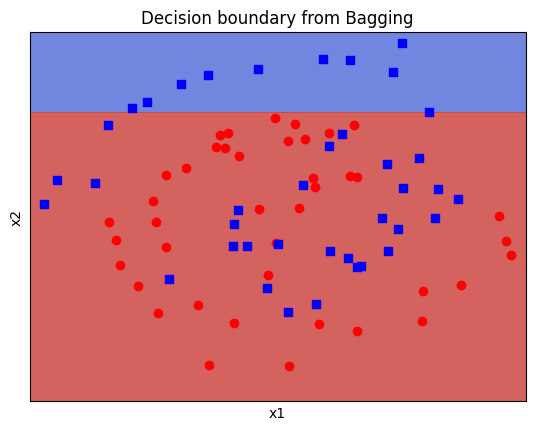

In [9]:
# create a mesh to plot in
h=0.02 #mesh step size
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

testX = np.c_[xx1.ravel(), xx2.ravel()]
#print(testX.shape) 
Z = compute_predictions(testX, decision_stumps)

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
#plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

idx_p = np.where(train_y == 1)
idx_n = np.where(train_y == -1)

plt.scatter(train_X[idx_p,0],train_X[idx_p,1], marker='o', color='red')
plt.scatter(train_X[idx_n,0],train_X[idx_n,1], marker='s', color='blue')

plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.xticks(())
plt.yticks(())
plt.title('Decision boundary from Bagging')
plt.show()


$\large{\text{Exercise}}$

Replace the weak learner in bagging with a decision tree which is built on random subset of samples and random subset of features. Check if the performance improves. 
